# 1 Inception Module

## 1.1 1×1卷积

## 1.2 完整代码

[1,   300] loss: 0.950
[1,   600] loss: 0.229
[1,   900] loss: 0.170
Accuracy on test set: 96 %
[2,   300] loss: 0.123
[2,   600] loss: 0.118
[2,   900] loss: 0.098
Accuracy on test set: 97 %
[3,   300] loss: 0.083
[3,   600] loss: 0.083
[3,   900] loss: 0.078
Accuracy on test set: 97 %
[4,   300] loss: 0.070
[4,   600] loss: 0.061
[4,   900] loss: 0.065
Accuracy on test set: 98 %
[5,   300] loss: 0.055
[5,   600] loss: 0.060
[5,   900] loss: 0.058
Accuracy on test set: 98 %
[6,   300] loss: 0.052
[6,   600] loss: 0.051
[6,   900] loss: 0.050
Accuracy on test set: 98 %
[7,   300] loss: 0.043
[7,   600] loss: 0.046
[7,   900] loss: 0.048
Accuracy on test set: 98 %
[8,   300] loss: 0.042
[8,   600] loss: 0.041
[8,   900] loss: 0.045
Accuracy on test set: 98 %
[9,   300] loss: 0.036
[9,   600] loss: 0.039
[9,   900] loss: 0.041
Accuracy on test set: 98 %
[10,   300] loss: 0.030
[10,   600] loss: 0.041
[10,   900] loss: 0.038
Accuracy on test set: 98 %


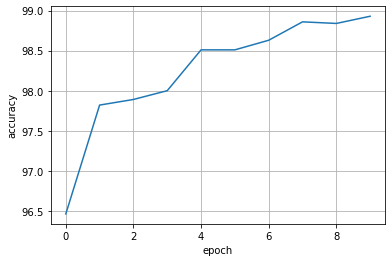

In [3]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1、准备数据集
batch_size = 64
transform = transforms.Compose([  # 一系列的操作，Compose将其组合在一起
    transforms.ToTensor(),  # 将图片转换为Tensor
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化到[0,1]，均值和方差
])
train_dataset = datasets.MNIST(root='../P6 逻辑斯谛回归/data', train=True,
                               download=False,  # 在P6 逻辑斯谛回归中我已下载，这里不用下载了
                               transform=transform)
test_dataset = datasets.MNIST(root='../P6 逻辑斯谛回归/data', train=False, download=False, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)  # 测试集设置为False，方便观察结果


# 2、设计模型

# 2.1 设计Inception块
class InceptionA(torch.nn.Module):
    def __init__(self, in_channels):  #in_channels为输入通道数
        super(InceptionA, self).__init__()
        self.branch1x1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)  # 1x1卷积

        self.branch5x5_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)  # 1x1卷积
        self.branch5x5_2 = torch.nn.Conv2d(16, 24, kernel_size=5, padding=2)  # 5x5卷积，padding=2保证输入输出大小一致

        self.branch3x3_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)  # 1x1卷积
        self.branch3x3_2 = torch.nn.Conv2d(16, 24, kernel_size=3, padding=1)  # 3x3卷积，padding=1保证输入输出大小一致
        self.branch3x3_3 = torch.nn.Conv2d(24, 24, kernel_size=3, padding=1)  # 3x3卷积

        self.branch_pool = torch.nn.Conv2d(in_channels, 24, kernel_size=1)  # 1x1卷积

    def forward(self, x):
        branch1x1 = self.branch1x1(x)  # 1x1卷积处理

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)  # 5x5卷积处理

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)

        # 最大池化torch.nn.MaxPool2d()是一个类，而这里的平均池化F.avg_pool2d()是一个函数
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)  # 平均池化处理,这里的padding=1,保证输入输出大小一致
        branch_pool = self.branch_pool(branch_pool)

        # 将四个分支的输出在通道维度上进行拼接
        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        return torch.cat(outputs, dim=1)  # dim=1表示在通道维度上进行拼接


# 2.2 设计网络
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(88, 20, kernel_size=5)  #这里的88是Inception块的输出通道数

        # 实例化Inception块，返回结果为88通道，因为Inception块中有四个分支，每个分支输出通道数为16+24+24+24=88
        self.incep1 = InceptionA(in_channels=10)
        self.incep2 = InceptionA(in_channels=20)

        self.mp = torch.nn.MaxPool2d(2)  # 池化层
        self.l1 = torch.nn.Linear(1408, 10)  # 全连接层,不确定第一个参数为多少时，可以先随便写一个，然后运行程序，看报错信息

    def forward(self, x):
        # Flatten data from (n, 1, 28, 28) to (n, 784)
        batch_size = x.size(0)  #获取batch_size,这里的batch_size=64
        x = F.relu(self.mp(self.conv1(x)))  # 经过第一个卷积层+池化层+激活函数
        x = self.incep1(x)  #经过第一个Inception块处理
        x = F.relu(self.mp(self.conv2(x)))  # 经过第二个卷积层+池化层+激活函数
        x = self.incep2(x)  #经过第二个Inception块处理
        x = x.view(batch_size, -1)  # 将数据展平，方便全连接层处理
        x = self.l1(x)  # 全连接层
        return x


model = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # 判断是否有GPU加速
model.to(device)  # 将模型放到GPU上

# 3、构建损失和优化器
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)  # 优化器,lr为学习率，momentum为动量


# 4、训练和测试
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # 将数据放到GPU上
        optimizer.zero_grad()  # 梯度清零
        # forward + backward + update
        outputs = model(inputs)  # outputs并不是概率，而是线性层的输出，但其大小顺序与概率分布相同
        loss = criterion(outputs, labels)
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

        running_loss += loss.item()
        if batch_idx % 300 == 299:  # 每300个batch打印一次平均loss
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0


def test():
    correct = 0
    total = 0
    with torch.no_grad():  # 测试过程中不需要计算梯度
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # 将数据放到GPU上
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)  # 返回每一行中最大值的那个元素，以及其索引
            total += labels.size(0)  # labels的size为[64]，即64个样本
            correct += (predicted == labels).sum().item()  # 统计预测正确的样本个数
    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)
    print('Accuracy on test set: %d %%' % accuracy)


if __name__ == '__main__':
    accuracy_list = []
    for epoch in range(10):
        train(epoch)
        test()
    plt.plot(accuracy_list)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.show()

从图像可以看出，在epoch为10时，**模型的准确率已经非常接近99%，并且还有上升的趋势**，说明Inception块的引入使得模型的预测能力更强了。

# 2 残差网络(Residual Network)

[1,   300] loss: 0.525
[1,   600] loss: 0.151
[1,   900] loss: 0.108
Accuracy on test set: 97 %
[2,   300] loss: 0.093
[2,   600] loss: 0.069
[2,   900] loss: 0.074
Accuracy on test set: 98 %
[3,   300] loss: 0.063
[3,   600] loss: 0.060
[3,   900] loss: 0.055
Accuracy on test set: 98 %
[4,   300] loss: 0.050
[4,   600] loss: 0.049
[4,   900] loss: 0.044
Accuracy on test set: 98 %
[5,   300] loss: 0.043
[5,   600] loss: 0.036
[5,   900] loss: 0.043
Accuracy on test set: 98 %
[6,   300] loss: 0.035
[6,   600] loss: 0.034
[6,   900] loss: 0.036
Accuracy on test set: 98 %
[7,   300] loss: 0.031
[7,   600] loss: 0.032
[7,   900] loss: 0.032
Accuracy on test set: 99 %
[8,   300] loss: 0.027
[8,   600] loss: 0.029
[8,   900] loss: 0.029
Accuracy on test set: 99 %
[9,   300] loss: 0.023
[9,   600] loss: 0.025
[9,   900] loss: 0.028
Accuracy on test set: 99 %
[10,   300] loss: 0.024
[10,   600] loss: 0.021
[10,   900] loss: 0.023
Accuracy on test set: 98 %


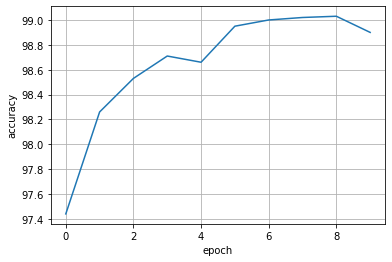

In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1、准备数据集
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='../P6 逻辑斯谛回归/data', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='../P6 逻辑斯谛回归/data', train=False, download=False, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)  # 测试集设置为False，方便观察结果


# 2、设计模型
# 2.1 残差块
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        # 定义两个卷积层,卷积核大小为3，padding=1保证输入输出大小一致,输入输出通道数一致，目的保证维度一致，能将输入与输出相加
        self.conv1 = torch.nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        y = F.relu(self.conv1(x))  # 第一个卷积层+激活函数
        y = self.conv2(y)  # 第二个卷积层+激活函数
        return F.relu(x + y)  # 将输入与输出相加，再经过激活函数


# 2.2 设计网络
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5)

        # 残差块
        self.res1 = ResidualBlock(16)
        self.res2 = ResidualBlock(32)

        self.mp = torch.nn.MaxPool2d(2)  # 最大池化层
        self.l1 = torch.nn.Linear(512, 10)  # 全连接层,不确定第一个参数为多少时，可以先随便写一个，然后运行程序，看报错信息

    def forward(self, x):
        # Flatten data from (n, 1, 28, 28) to (n, 784)
        batch_size = x.size(0)  #获取batch_size,这里的batch_size=64
        x = self.mp(F.relu(self.conv1(x)))  # 经过第一个卷积层+激活函数+池化层
        x = self.res1(x)  #经过第一个残差块处理
        x = self.mp(F.relu(self.conv2(x)))  # 经过第二个卷积层+激活函数+池化层
        x = self.res2(x)  #经过第二个Inception块处理
        x = x.view(batch_size, -1)  # 将数据展平，方便全连接层处理
        x = self.l1(x)  # 全连接层
        return x


model = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # 判断是否有GPU加速
model.to(device)  # 将模型放到GPU上

# 3、构建损失和优化器
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)  # 优化器,lr为学习率，momentum为动量


# 4、训练和测试
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # 将数据放到GPU上
        optimizer.zero_grad()  # 梯度清零
        # forward + backward + update
        outputs = model(inputs)  # outputs并不是概率，而是线性层的输出，但其大小顺序与概率分布相同
        loss = criterion(outputs, labels)
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

        running_loss += loss.item()
        if batch_idx % 300 == 299:  # 每300个batch打印一次平均loss
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0


def test():
    correct = 0
    total = 0
    with torch.no_grad():  # 测试过程中不需要计算梯度
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # 将数据放到GPU上
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)  # 返回每一行中最大值的那个元素，以及其索引
            total += labels.size(0)  # labels的size为[64]，即64个样本
            correct += (predicted == labels).sum().item()  # 统计预测正确的样本个数
    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)
    print('Accuracy on test set: %d %%' % accuracy)


if __name__ == '__main__':
    accuracy_list = []
    for epoch in range(10):
        train(epoch)
        test()
    plt.plot(accuracy_list)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.show()